In [35]:
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset 
import numpy as np
import geopandas as gpd
import osmnx as ox
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
%matplotlib inline

In [4]:
nc_file = 'era5_lahaina.nc'
nc_data = Dataset(nc_file, mode='r')  # read-only

print("File opened with netCDF4!")

print(nc_data)

File opened with netCDF4!
<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    GRIB_centre: ecmf
    GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre: 0
    Conventions: CF-1.7
    institution: European Centre for Medium-Range Weather Forecasts
    history: 2025-01-16T17:12 GRIB to CDM+CF via cfgrib-0.9.14.1/ecCodes-2.36.0 with {"source": "data.grib", "filter_by_keys": {"stream": ["oper"], "stepType": ["instant"]}, "encode_cf": ["parameter", "time", "geography", "vertical"]}
    dimensions(sizes): valid_time(96), latitude(9), longitude(17)
    variables(dimensions): int64 number(), int64 valid_time(valid_time), float64 latitude(latitude), float64 longitude(longitude), <class 'str'> expver(valid_time), float32 u10(valid_time, latitude, longitude), float32 v10(valid_time, latitude, longitude), float32 d2m(valid_time, latitude, longitude), float32 t2m(valid_time, latitude, longitude), float32 sp(valid_time, latitude,

In [8]:
print(nc_data.variables["u10"].dimensions)

('valid_time', 'latitude', 'longitude')


In [6]:
east_wind_u10 = nc_data.variables["u10"][:]
north_wind_v10 = nc_data.variables["v10"][:]

In [7]:
east_wind_u10.shape

(96, 9, 17)

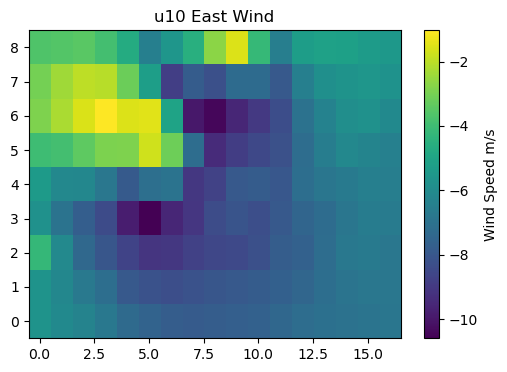

In [9]:
time_index = 0
plt.figure(figsize=(6, 4))
plt.imshow(east_wind_u10[time_index, :, :], origin='lower', aspect='auto') 
plt.colorbar(label='Wind Speed m/s')
plt.title("u10 East Wind")
plt.show()

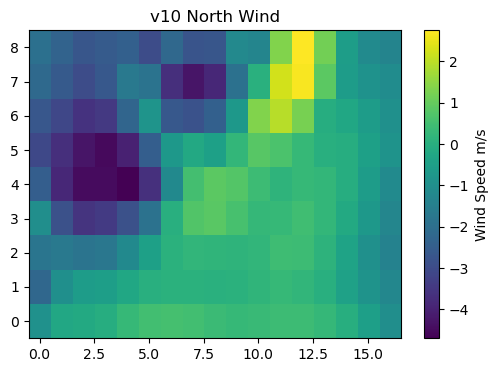

In [10]:
time_index = 0
plt.figure(figsize=(6, 4))
plt.imshow(north_wind_v10[time_index, :, :], origin='lower', aspect='auto') 
plt.colorbar(label='Wind Speed m/s')
plt.title("v10 North Wind")
plt.show()

In [12]:
ds = xr.open_dataset('era5_lahaina.nc')
ds

<xarray.Dataset> Size: 531kB
Dimensions:     (valid_time: 96, latitude: 9, longitude: 17)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 768B 2023-08-07 ... 2023-08-10T23...
  * latitude    (latitude) float64 72B 22.0 21.75 21.5 21.25 ... 20.5 20.25 20.0
  * longitude   (longitude) float64 136B -158.0 -157.8 -157.5 ... -154.2 -154.0
    expver      (valid_time) <U4 2kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 59kB ...
    v10         (valid_time, latitude, longitude) float32 59kB ...
    d2m         (valid_time, latitude, longitude) float32 59kB ...
    t2m         (valid_time, latitude, longitude) float32 59kB ...
    sp          (valid_time, latitude, longitude) float32 59kB ...
    u100        (valid_time, latitude, longitude) float32 59kB ...
    v100        (valid_time, latitude, longitude) float32 59kB ...
    u10n        (valid_time, latitude, longitude) float32 59kB ...
    v10n        (valid_time, latitude, longitude) float32 59kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-16T17:12 GRIB to CDM+CF via cfgrib-0.9.1...

In [15]:
ds.data_vars

Data variables:
    u10      (valid_time, latitude, longitude) float32 59kB ...
    v10      (valid_time, latitude, longitude) float32 59kB ...
    d2m      (valid_time, latitude, longitude) float32 59kB ...
    t2m      (valid_time, latitude, longitude) float32 59kB ...
    sp       (valid_time, latitude, longitude) float32 59kB ...
    u100     (valid_time, latitude, longitude) float32 59kB ...
    v100     (valid_time, latitude, longitude) float32 59kB ...
    u10n     (valid_time, latitude, longitude) float32 59kB ...
    v10n     (valid_time, latitude, longitude) float32 59kB ...

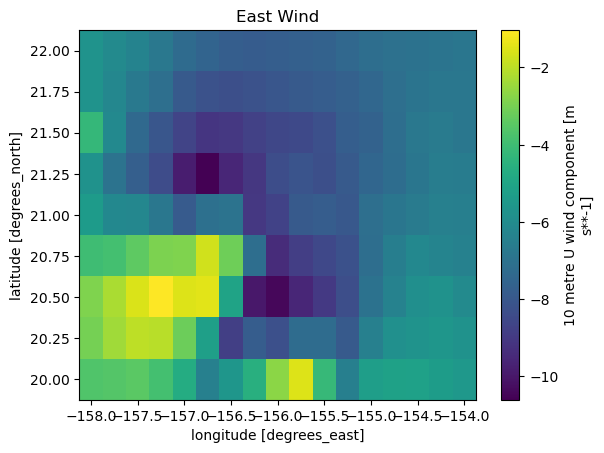

In [19]:
ds["u10"].isel(valid_time=0).plot()
plt.title("East Wind")
plt.show()

In [23]:
u = ds["u10"]
v = ds["v10"]

# wind speed: sqrt(u^2 + v^2)
wind_speed = np.sqrt(u**2 + v**2)

# Optionally give it a name and attributes
wind_speed.name = "wind_speed"
wind_speed.attrs["units"] = "m s-1"

# direction_to: arctan2(v, u), in degrees
wind_dir_to = np.degrees(np.arctan2(v, u))

# Convert from [-180, 180] to [0, 360) if desired
wind_dir_to = (wind_dir_to + 360) % 360
wind_dir_to.name = "wind_direction_to"
wind_dir_to.attrs["units"] = "degrees from East (counter-clockwise)"

# direction_from: 0° = from North, angles increase clockwise
wind_dir_from = (270 - np.degrees(np.arctan2(v, u))) % 360
wind_dir_from.name = "wind_direction_from"
wind_dir_from.attrs["units"] = "degrees from North (clockwise)"

# Combine these into a single dataset for convenience
ds_wind = xr.Dataset({
    "wind_speed": wind_speed,
    "wind_dir_to": wind_dir_to,
    "wind_dir_from": wind_dir_from
})

ds_wind

<xarray.Dataset> Size: 179kB
Dimensions:        (valid_time: 96, latitude: 9, longitude: 17)
Coordinates:
    number         int64 8B 0
  * valid_time     (valid_time) datetime64[ns] 768B 2023-08-07 ... 2023-08-10...
  * latitude       (latitude) float64 72B 22.0 21.75 21.5 ... 20.5 20.25 20.0
  * longitude      (longitude) float64 136B -158.0 -157.8 ... -154.2 -154.0
    expver         (valid_time) <U4 2kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    wind_speed     (valid_time, latitude, longitude) float32 59kB 5.755 ... 7...
    wind_dir_to    (valid_time, latitude, longitude) float32 59kB 189.3 ... 2...
    wind_dir_from  (valid_time, latitude, longitude) float32 59kB 80.74 ... 6...

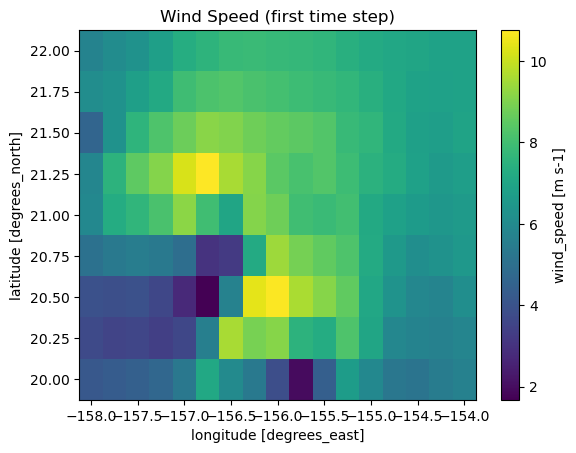

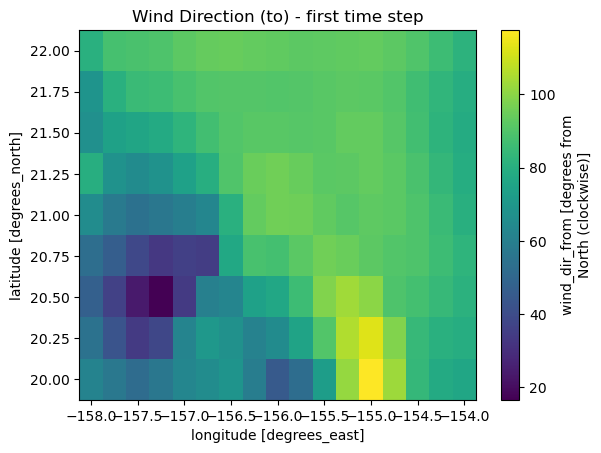

In [26]:
# Plot wind speed
ds_wind["wind_speed"].isel(valid_time=0).plot()
plt.title("Wind Speed (first time step)")
plt.show()

# Plot wind direction (to)
ds_wind["wind_dir_from"].isel(valid_time=0).plot()
plt.title("Wind Direction (to) - first time step")
plt.show()

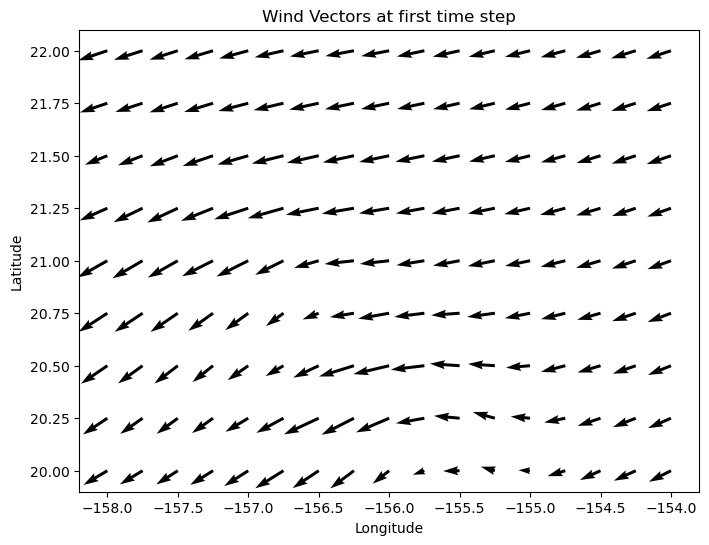

In [33]:
time_point=68
lat = ds["latitude"].values  # or ds["lat"].values
lon = ds["longitude"].values # or ds["lon"].values
U = ds["u10"].isel(valid_time=time_point).values
V = ds["v10"].isel(valid_time=time_point).values

plt.figure(figsize=(8, 6))
plt.quiver(lon, lat, U, V)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Wind Vectors at first time step")
plt.show()

In [31]:
ds_wind["wind_dir_from"].isel(valid_time=0).values

array([[ 80.74371 ,  87.771515,  88.429504,  89.44623 ,  92.23001 ,
         93.75328 ,  94.129166,  93.52365 ,  92.83786 ,  92.18257 ,
         92.630875,  93.11307 ,  93.35301 ,  92.239426,  89.776886,
         85.97504 ,  81.44162 ],
       [ 68.77548 ,  80.89441 ,  84.96619 ,  85.88626 ,  88.150665,
         90.06203 ,  90.46626 ,  90.52069 ,  90.209015,  90.40997 ,
         91.304276,  92.14226 ,  91.666   ,  90.01619 ,  86.45621 ,
         82.63092 ,  79.707275],
       [ 66.87988 ,  74.41376 ,  76.07614 ,  77.82645 ,  82.44214 ,
         87.09415 ,  90.30995 ,  91.3609  ,  91.23337 ,  90.996765,
         91.480225,  93.14821 ,  93.17723 ,  91.05325 ,  86.87024 ,
         81.791016,  78.29648 ],
       [ 80.00568 ,  67.7504  ,  65.10962 ,  67.809265,  73.85498 ,
         79.92749 ,  89.953674,  94.528946,  95.774765,  94.14719 ,
         91.79445 ,  92.22002 ,  93.46802 ,  91.90796 ,  88.51752 ,
         83.59253 ,  78.97473 ],
       [ 65.42444 ,  57.86969 ,  54.111145,  56.6203

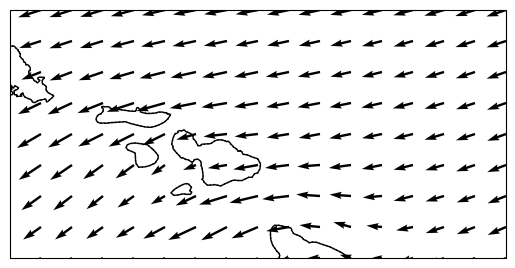

In [38]:
# Create a cartopy map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-158, -154, 20, 22], crs=ccrs.PlateCarree())

# Add some built-in features (coastlines, borders, states)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Optionally overlay your wind data here (e.g., quiver or pcolormesh)
ax.quiver(lon, lat, U, V, transform=ccrs.PlateCarree())

plt.show()